In [1]:
# Common imports for both tasks
import pandas as pd
import requests
from pymongo import MongoClient
from psycopg2 import extras
import psycopg2
import xml.etree.ElementTree as ET
from itertools import islice
from concurrent.futures import ThreadPoolExecutor
import luigi

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
"host": "localhost",
"database": "postgres",
"user": "postgres",
"password": "Thanksgiving2024"
}


In [2]:
import requests
import pandas as pd
from pymongo import MongoClient
import xml.etree.ElementTree as ET
from itertools import islice
from concurrent.futures import ThreadPoolExecutor

# MongoDB connection URI
mongo_uri = "mongodb://localhost:27017/"

# Function to fetch XML data from the URL
def fetch_xml_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        print("Failed to fetch XML data")
        return None

# Function to parse XML data and insert into MongoDB
def insert_xml_to_mongodb(records, collection_name):
    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]

    collection.insert_many(records)
    client.close()
    print(f"{len(records)} records inserted into MongoDB.")

# Function to process XML data and store in MongoDB
def process_and_store_data(xml_data, collection_name, limit):
    root = ET.fromstring(xml_data)
    records = []
    for row in islice(root.iter('row'), limit):
        data = {}
        for child in row:
            data[child.tag] = child.text
        records.append(data)
    insert_xml_to_mongodb(records, collection_name)

# Function to handle data fetching and processing concurrently
def handle_data(url, collection_name, limit):
    xml_data = fetch_xml_data(url)
    if xml_data:
        process_and_store_data(xml_data, collection_name, limit)
        print("Data processing and insertion completed.")
    else:
        print("Failed to process data.")



# Main function to execute the process
def main():
    tasks = [
        ("https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.xml?accessType=DOWNLOAD", "CrashReporting", 1500)
    ]


    with ThreadPoolExecutor(max_workers=3) as executor:
        for url, collection_name, limit in tasks:
            executor.submit(handle_data, url, collection_name, limit)
        

if __name__ == "__main__":
    main()

1500 records inserted into MongoDB.
Data processing and insertion completed.


LUIGI ETL PROCESS FROM MONGODB TO POSTGRESS

In [3]:
import luigi
import psycopg2
import pandas as pd
import numpy as np
from pymongo import MongoClient
from psycopg2 import extras
from luigi import LocalTarget

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

class FetchDataFromMongo(luigi.Task):
    collection_name = luigi.Parameter()
    
    def output(self):
        return LocalTarget(f"data_{self.collection_name}.csv")
    
    def run(self):
        client = MongoClient(mongo_uri)
        db = client.DatabaseAnalytics
        collection = db[self.collection_name]
        data = pd.DataFrame(list(collection.find().limit(1300)))
        client.close()
        
        data.to_csv(self.output().path, index=False)

class TransformData(luigi.Task):
    collection_name = luigi.Parameter()
    
    def requires(self):
        return FetchDataFromMongo(self.collection_name)
    
    def output(self):
        return LocalTarget(f"transformed_data_{self.collection_name}.csv")
    
    def run(self):
        df = pd.read_csv(self.input().path)
        
        # Transform logic here
        if '_id' in df.columns:
            df['_id'] = df['_id'].astype(str)
        df.fillna(value=np.nan, inplace=True)
        df.replace({np.nan: None}, inplace=True)
        
        df.to_csv(self.output().path, index=False)

class LoadDataToPostgres(luigi.Task):
    collection_name = luigi.Parameter()
    table_name = luigi.Parameter()

    def requires(self):
        return TransformData(self.collection_name)
    
    def output(self):
        return LocalTarget(f"{self.table_name}_load_done.txt")
    
    def run(self):
        df = pd.read_csv(self.input().path)
        conn = psycopg2.connect(**pg_params)
        cur = conn.cursor()
        try:
            # Create table
            cur.execute(f"DROP TABLE IF EXISTS {self.table_name};")
            sql_create_table = f"CREATE TABLE {self.table_name} ("
            column_definitions = []
            for column, dtype in zip(df.columns, df.dtypes):
                sql_type = "TEXT"
                if "int" in str(dtype):
                    sql_type = "INTEGER"
                elif "float" in str(dtype):
                    sql_type = "NUMERIC"
                elif "datetime" in str(dtype):
                    sql_type = "TIMESTAMP"
                column_definitions.append(f"{column} {sql_type}")
            sql_create_table += ", ".join(column_definitions) + ");"
            cur.execute(sql_create_table)

            # Load data
            columns = list(df.columns)
            sql = f"INSERT INTO {self.table_name} ({', '.join(columns)}) VALUES %s"
            tuples = [tuple(x) for x in df.to_numpy()]
            extras.execute_values(cur, sql, tuples)
            conn.commit()
            
            # Write the success file
            with self.output().open('w') as f:
                f.write('Data load complete')
        except Exception as e:
            print(f"An error occurred: {e}")
        finally:
            cur.close()
            conn.close()

class MongoToPostgresPipeline(luigi.WrapperTask):
    def requires(self):
        collections_to_tables = {
            "CrashReporting": "crash_reporting",
            # Add other collections and tables here
        }
        
        for collection_name, table_name in collections_to_tables.items():
            yield LoadDataToPostgres(collection_name=collection_name, table_name=table_name)

if __name__ == "__main__":
    luigi.build([MongoToPostgresPipeline()], local_scheduler=True)


DEBUG: Checking if MongoToPostgresPipeline() is complete
DEBUG: Checking if LoadDataToPostgres(collection_name=CrashReporting, table_name=crash_reporting) is complete
INFO: Informed scheduler that task   MongoToPostgresPipeline__99914b932b   has status   PENDING
DEBUG: Checking if TransformData(collection_name=CrashReporting) is complete
INFO: Informed scheduler that task   LoadDataToPostgres_CrashReporting_crash_reporting_762ae342f0   has status   PENDING
DEBUG: Checking if FetchDataFromMongo(collection_name=CrashReporting) is complete
INFO: Informed scheduler that task   TransformData_CrashReporting_ed9966fc94   has status   PENDING
INFO: Informed scheduler that task   FetchDataFromMongo_CrashReporting_ed9966fc94   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 4
INFO: [pid 53824] Worker Worker(salt=7213901535, workers=1, host=LynettPC, username=lynne, pid=53824) running   FetchDataFromM

Visualizations - Crash Reporting

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

conn = psycopg2.connect(**pg_params)
warnings.filterwarnings("ignore")
# Query data from the crash_reporting table
query = "SELECT * FROM crash_reporting;"
data = pd.read_sql(query, conn)

conn.close()

Descriptive Analysis Below

In [5]:
# Display the first few rows of the data
print(data.head())

# Display basic statistics of numerical columns
print(data.describe())

# Check the data types of each column
print(data.dtypes)

                        _id  row report_number  local_case_number  \
0  6633bcc2312109ccefbc03c8  NaN           NaN                NaN   
1  6633bcc2312109ccefbc03c9  NaN   MCP3170003V        240000438.0   
2  6633bcc2312109ccefbc03ca  NaN   MCP3254003K        230072050.0   
3  6633bcc2312109ccefbc03cb  NaN    EJ7887003Q        230074270.0   
4  6633bcc2312109ccefbc03cc  NaN   MCP2674004J        230064598.0   

                 agency_name       acrs_report_type      crash_date_time  \
0                        NaN                    NaN                  NaN   
1   Montgomery County Police  Property Damage Crash  2024-01-03T14:55:00   
2   Montgomery County Police           Injury Crash  2023-12-16T12:36:00   
3  Gaithersburg Police Depar           Injury Crash  2023-12-29T12:00:00   
4   Montgomery County Police  Property Damage Crash  2023-11-05T21:07:00   

            off_road_description                collision_type weather  ...  \
0                            NaN                 

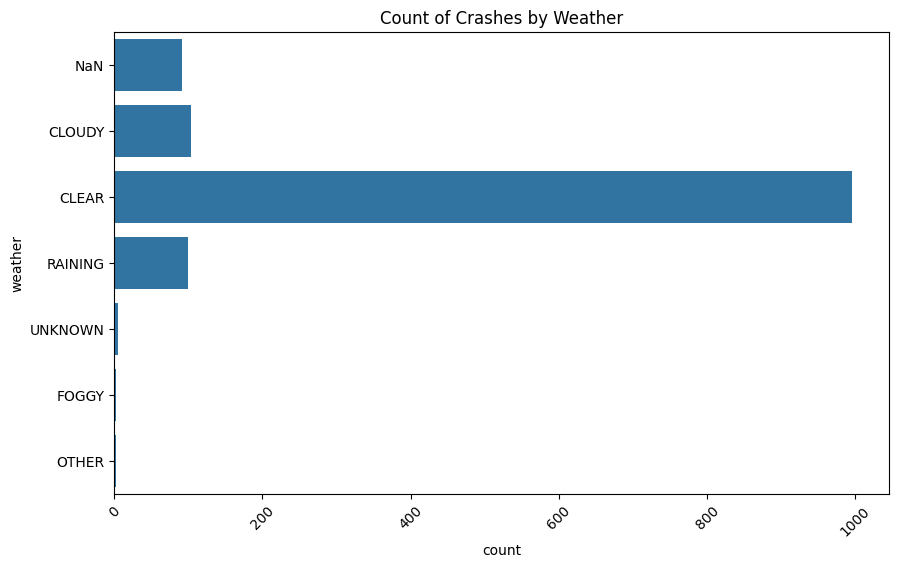

In [6]:
# Plot count plots for categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(data['weather'])
plt.title('Count of Crashes by Weather')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Statistics for numerical columns
numerical_stats = data.describe()

# Display basic statistics
print("Basic Statistics for Numerical Columns:")
print(numerical_stats)

Basic Statistics for Numerical Columns:
       row  local_case_number  speed_limit  vehicle_year     latitude  \
count  0.0       1.299000e+03  1299.000000   1299.000000  1299.000000   
mean   NaN       2.269587e+08    31.447267   1975.391070    39.086101   
std    NaN       2.437568e+07    10.882803    371.874388     0.071159   
min    NaN       2.300138e+07     0.000000      0.000000    38.945128   
25%    NaN       2.300349e+08    25.000000   2010.000000    39.028040   
50%    NaN       2.300468e+08    35.000000   2015.000000    39.078028   
75%    NaN       2.300482e+08    35.000000   2019.000000    39.141925   
max    NaN       2.400014e+08    65.000000   9999.000000    39.330648   

         longitude  geolocation  
count  1299.000000          0.0  
mean    -77.112717          NaN  
std       0.095415          NaN  
min     -77.390534          NaN  
25%     -77.196393          NaN  
50%     -77.109881          NaN  
75%     -77.036293          NaN  
max     -76.914840          Na

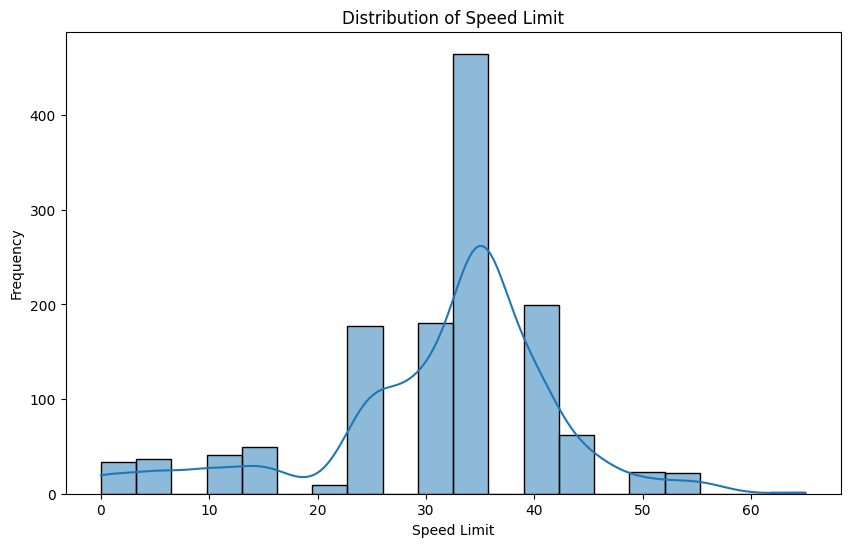

In [8]:
# histogram for numerical variables
plt.figure(figsize=(10, 6))
sns.histplot(data['speed_limit'], bins=20, kde=True)
plt.title('Distribution of Speed Limit')
plt.xlabel('Speed Limit')
plt.ylabel('Frequency')
plt.show()

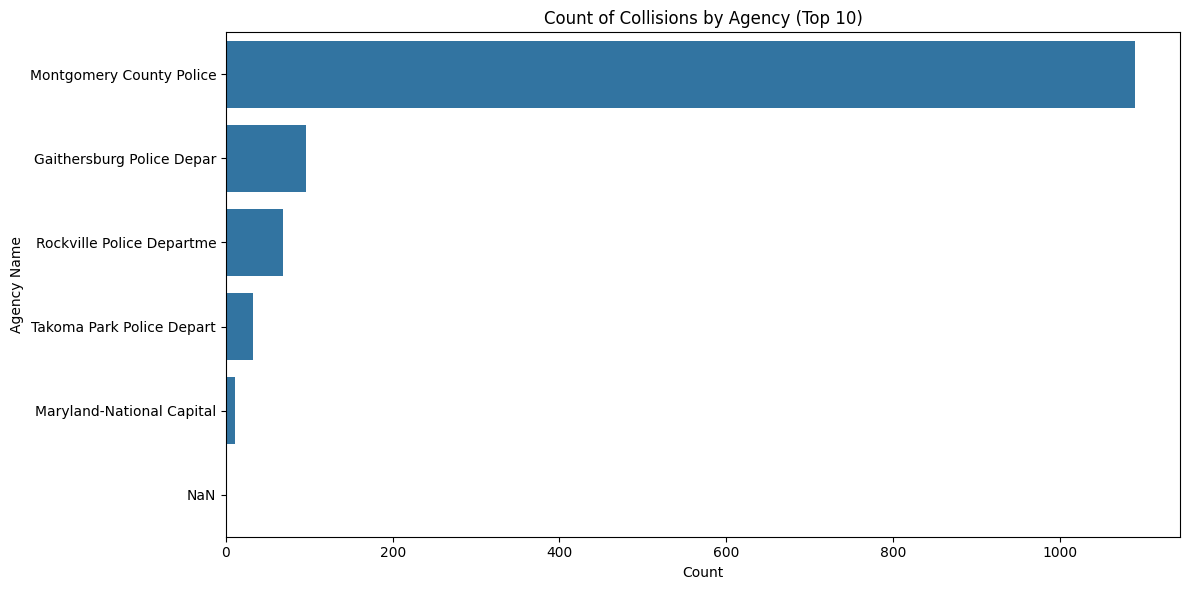

In [9]:
# Count of Collisions by Agency
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='agency_name', order=data['agency_name'].value_counts().index[:10])
plt.title('Count of Collisions by Agency (Top 10)')
plt.xlabel('Count')
plt.ylabel('Agency Name')
plt.tight_layout()
plt.show()

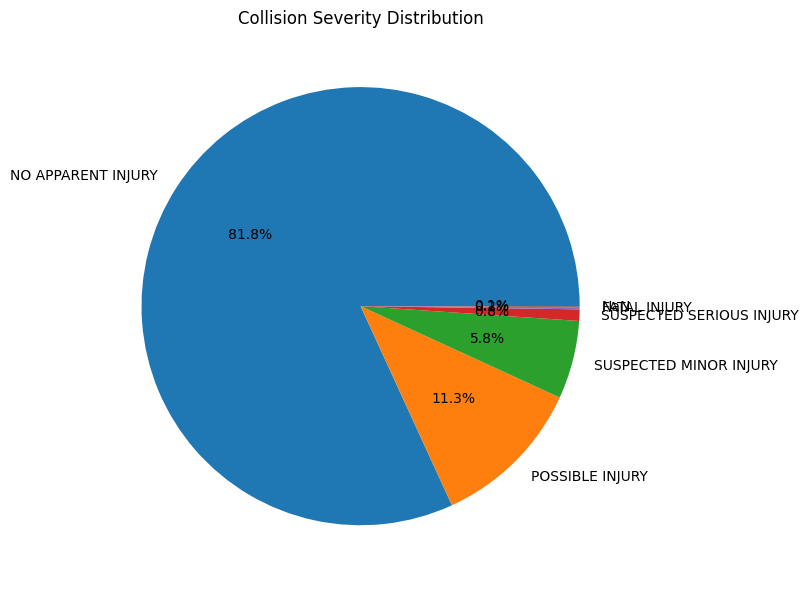

In [10]:
plt.figure(figsize=(8, 6))
data['injury_severity'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Collision Severity Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

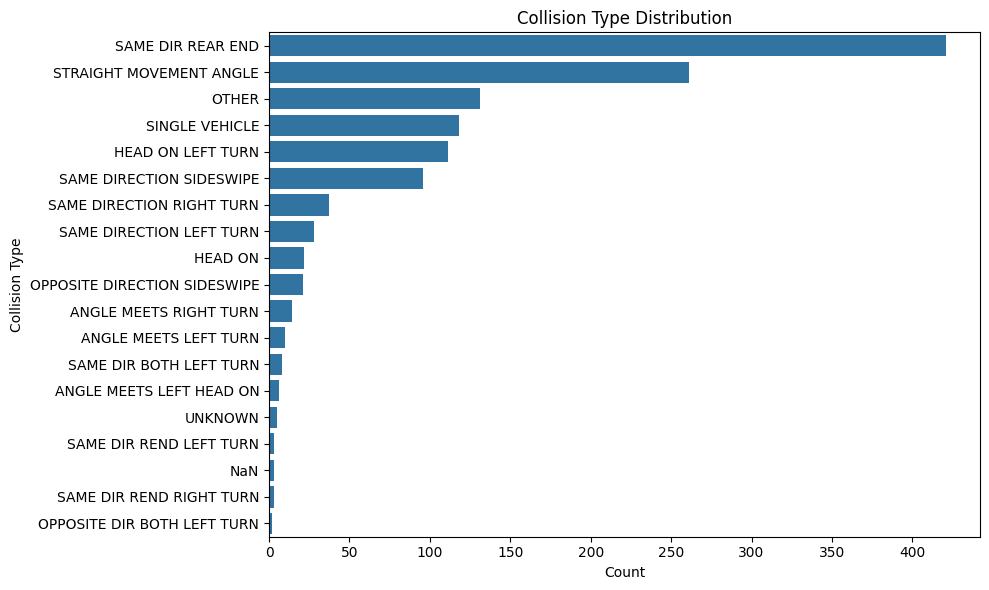

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='collision_type', order=data['collision_type'].value_counts().index)
plt.title('Collision Type Distribution')
plt.xlabel('Count')
plt.ylabel('Collision Type')
plt.tight_layout()
plt.show()

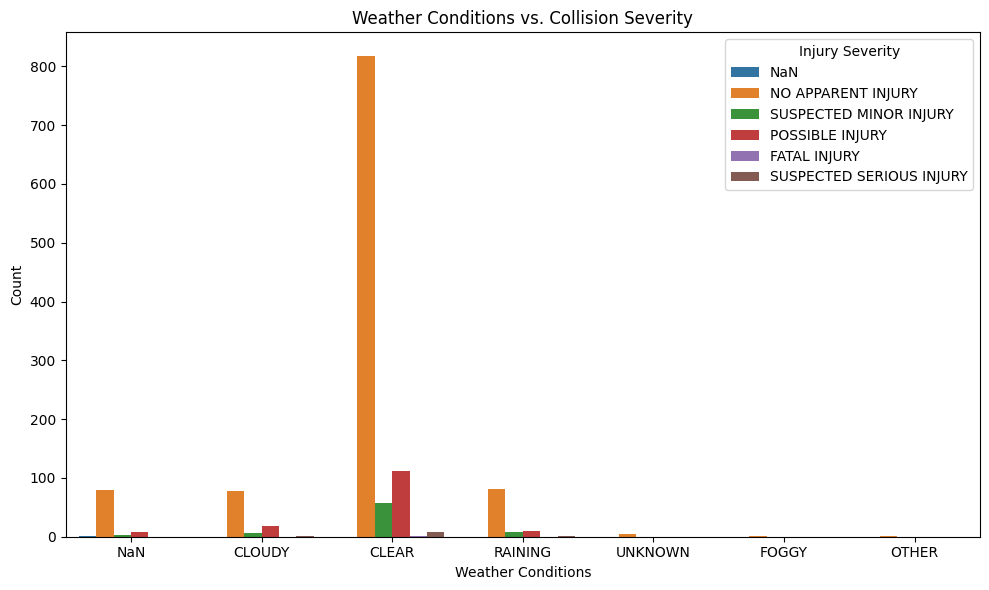

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='weather', hue='injury_severity')
plt.title('Weather Conditions vs. Collision Severity')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()

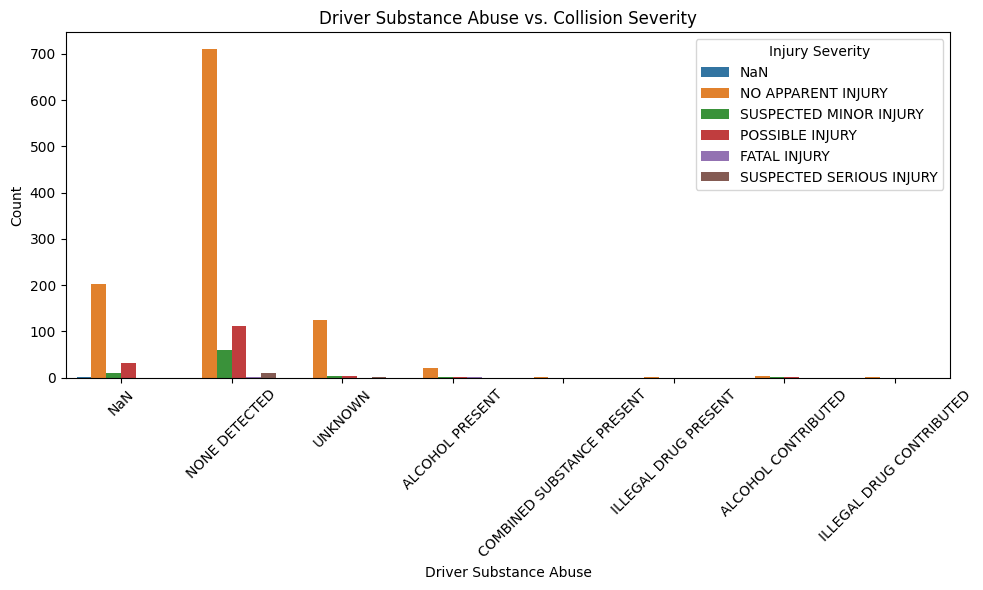

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='driver_substance_abuse', hue='injury_severity')
plt.title('Driver Substance Abuse vs. Collision Severity')
plt.xlabel('Driver Substance Abuse')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()

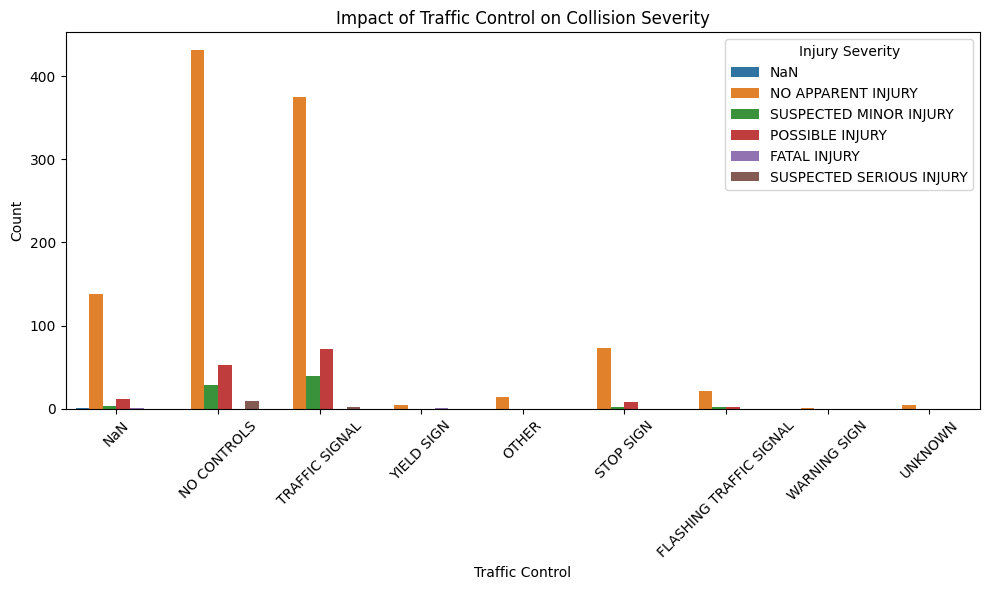

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='traffic_control', hue='injury_severity')
plt.title('Impact of Traffic Control on Collision Severity')
plt.xlabel('Traffic Control')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()